<a href="https://colab.research.google.com/github/keweiang/AISanomalydetection/blob/main/Copy_of_AISAnomalyDetectionSystem(2_class).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
from geopy import distance
import matplotlib.pyplot as plt
import os
import h5py
from datetime import date, time, datetime
from itertools import groupby
from operator import itemgetter
import math
from os.path import join
interactive = True
headers=['index1', 'date time','mmsi','rot','sog','y','x','cog','true_heading','timestamp','AIS_channel']

In [3]:
power_outage = 70 # define max distance from AIS receiver for power outage
ANTENNA = (1.5699,103.6447)
MISS_NUM = -1
CLASSES = 3
EXTRA_FEATURES = 0 # one for distance, and another for time to last seen
SAMPLING_TIME = 2 # seconds
num_of_vessels = 150

In [4]:
def load_all_data(timesteps, dim, features, CLASSES):
    ############## generate data from read_csv to train ANN ##
    np.random.seed(10)
    EXTRA_FEATURES = 0
    if CLASSES == 3:
        EXTRA_FEATURES = 1
    column_len = dim * timesteps + EXTRA_FEATURES
    ano_condition = 0.9 * timesteps*dim

    with open('/content/drive/MyDrive/AISdata (2).csv', 'r') as f:
        data = pd.read_csv(f,skiprows=1,names=headers,usecols=range(1,11))
    
    with open('/content/drive/MyDrive/data_all_tracks.csv', 'r') as f:
        data_all_tracks = pd.read_csv(f)
    
    overall_data = np.full(shape=(int(sum(data_all_tracks['count'])+timesteps*len(data_all_tracks)+data.shape[0]), column_len), fill_value=-1.0)
    data1 = data.mmsi.unique()
    startIndex = 0

    for mmsi in data1[:num_of_vessels]:

        decoded_mmsi = data[data['mmsi'] == mmsi]

        if decoded_mmsi.shape[0] > timesteps:
            # decoded_mmsi = decoded_mmsi.reset_index(drop=True)
            print("Decoded_mmsi:\n",decoded_mmsi)

            start_time = datetime.strptime(decoded_mmsi.iloc[0]['date time'],'%m/%d/%Y %H:%M')
            end_time = datetime.strptime(decoded_mmsi.iloc[-1]['date time'],'%m/%d/%Y %H:%M')
            data_per_track = int((end_time - start_time).total_seconds() // SAMPLING_TIME + 1)
            print("Data per track: ",data_per_track)
            
            # place ais info on first 4 columns
            for slot_index in range(0, decoded_mmsi.shape[0]):  
                # print("DecodedMMSI:\nBefore:\n",decoded_mmsi)
                current_time = datetime.strptime(decoded_mmsi.iloc[slot_index]['date time'], '%m/%d/%Y %H:%M')
                index1 = int((current_time - start_time).total_seconds()) // SAMPLING_TIME
                overall_data[index1, 0:dim] = decoded_mmsi.iloc[slot_index, 3:7]
                # print("Overall_data:\nAfter:\n",overall_data)
             
            # shift from top and put on remaining columns
            for clm_num in range(1, timesteps):
                try: 
                    overall_data[startIndex : startIndex + data_per_track  - clm_num,
                clm_num * dim:(clm_num + 1) * dim] = overall_data[startIndex +1 : startIndex +data_per_track - clm_num + 1, (clm_num - 1) * dim:clm_num * dim]   
                 
                except ValueError as e:
                    err = str(e)
                    print(err) 
                    continue    #error HERE!!! LHS shape not fitting RHS started at 566530000

            
            try:    
                overall_data[startIndex+data_per_track: startIndex + data_per_track + decoded_mmsi.shape[0], 0:dim] = decoded_mmsi.iloc[:, 3:7]
            except ValueError:
                overall_data[startIndex+data_per_track: startIndex + data_per_track + decoded_mmsi.shape[0], 0:dim] = decoded_mmsi.iloc[0, 3:7] 
            startIndex += data_per_track + decoded_mmsi.shape[0]
            # print("Overall data again&again:\nAfter:\n",overall_data)

    if (CLASSES == 2):
        overall_data = overall_data[np.where(overall_data[:, 0:1] >= 0)[0]]
        # compute number of missing zeros after the first meassage in each row
        index_clm = np.argmax(overall_data[:, dim:timesteps * dim] >= 0,
                              axis=1)  # np argmax returns 0 if a row has all data < 0
        index_zeros = np.where((index_clm == 0))[0]
        index_zero = index_zeros[np.where((overall_data[index_zeros, dim] == MISS_NUM))[0]]
        index_clm[index_zero] = (timesteps - 1) * dim
        ind_ano = np.where(index_clm >= ano_condition)[0]
        ind_normal = np.where(index_clm < ano_condition)[0]
        # column number (timesteps + 1) * dim  stores passed time since last received ais message

        # column number (timesteps + 1) * dim + 1 stores distance of vessels from Rostock

        # assign target values
        Y_data = np.zeros((overall_data.shape[0], CLASSES))
        Y_data[:, 0] = 1
        Y_data[ind_ano] = [0, 1]
        print('total number of anomaly samples is ', len(ind_ano))
        print('total number of normal samples is ', len(Y_data) - len(ind_ano))
    else:
        index_zero = np.where(np.sum(overall_data == MISS_NUM, axis=1)== column_len)[0]

        ind_nonzero = np.where(overall_data[:,0:1] >= 0)[0]

        if (len(index_zero)> len(ind_nonzero)):
            new_data = overall_data[ind_nonzero[0:len(ind_nonzero)//2], 0:dim]
            new_data[0:len(ind_nonzero)//4,0] = np.random.uniform(11, 11.4, len(ind_nonzero)//4)
            new_data[0:len(ind_nonzero)//4, 1] = np.random.uniform(54, 55, len(ind_nonzero)//4)
            new_data[len(ind_nonzero) // 4:len(ind_nonzero) // 2, 0] = np.random.uniform(12.4, 13, len(ind_nonzero) // 2 -len(ind_nonzero) // 4)
            new_data[len(ind_nonzero) // 4:len(ind_nonzero) // 2, 1] = np.random.uniform(54.4, 55, len(ind_nonzero) // 2 -len(ind_nonzero) // 4)
            overall_data[index_zero[0:len(ind_nonzero)//2],0:dim] = new_data
        else:
            print('do something else')


        overall_data = overall_data[np.where(overall_data[:,0:1] >= 0)[0]]
        # compute number of missing zeros after the first meassage in each row
        index_clm = np.argmax(overall_data[:, dim:timesteps*dim] >= 0, axis = 1) # np argmax returns 0 if a row has all data < 0
        index_zeros = np.where((index_clm == 0))[0]
        index_zero = index_zeros[np.where((overall_data[index_zeros, dim] == MISS_NUM))[0]]
        index_clm[index_zero] = (timesteps-1)*dim
        ind_ano = np.where(index_clm >= ano_condition)[0]
        ind_normal = np.where(index_clm < ano_condition)[0]

        # assign target values
        Y_data = np.zeros((overall_data.shape[0], CLASSES))
        Y_data[:, 0] = 1
       
        distance_from_Rostock = np.floor(np.sqrt(
            (ANTENNA[0] - overall_data[:, 0]) ** 2 + (ANTENNA[1] - overall_data[:, 1]) ** 2) * 1.85 * 60)
        overall_data[:,-1] = distance_from_Rostock
        ind_po = np.where((distance_from_Rostock[ind_ano] >= power_outage) )[0]
        Y_data[ind_ano[ind_po]]= [0, 1, 0]
        print('total number of power outage samples is ',len(ind_po))
        ind_ano1 = np.where((distance_from_Rostock[ind_ano] < power_outage) )[0]
        Y_data[ind_ano[ind_ano1]] = [0, 0, 1]
        print('total number of anomaly samples is ', len(ind_ano1))
        print('total number of normal samples is ', len(ind_normal))

    
        # overallData_table=pd.DataFrame(overall_data)
        # Ydata_table=pd.DataFrame(Y_data,columns=['normal','powerOutage','abnormal'])
        # truth_values_1=pd.concat([overallData_table, Ydata_table], axis=1)
        # print(truth_values_1)
        
        # # selecting rows based on condition
        # abnormalV = truth_values_1[truth_values_1['abnormal'] ==1]
        # print('\nAbnormal vessels in dataframe :\n', abnormalV)
        # abnormalV.to_csv("AbnormalV.csv", index=False)


    return overall_data, Y_data

Decoded_mmsi:
            date time       mmsi  rot  sog           y         x    cog  \
0     10/1/2019 3:57  566241000    0  0.0  103.782597  1.274448   18.8   
1     10/1/2019 4:09  566241000    0  0.0  103.782650  1.274480   18.8   
2     10/1/2019 4:15  566241000    0  0.0  103.782645  1.274455   18.8   
3     10/1/2019 4:34  566241000    0  0.0  103.782647  1.274438   18.8   
4     10/1/2019 4:36  566241000    0  0.0  103.782602  1.274432   18.8   
..               ...        ...  ...  ...         ...       ...    ...   
310  10/3/2019 18:35  566241000    0  0.0  103.956068  1.291622  109.3   
311  10/3/2019 21:23  566241000    0  0.0  103.955935  1.291995  109.3   
312  10/3/2019 22:46  566241000  127  0.5  103.954773  1.292093  147.7   
313  10/3/2019 22:47  566241000    0  0.9  103.954822  1.291962  165.5   
314  10/3/2019 22:47  566241000    0  0.9  103.954842  1.291875  170.6   

     true_heading  timestamp AIS_channel  
0             126         29           A  
1         

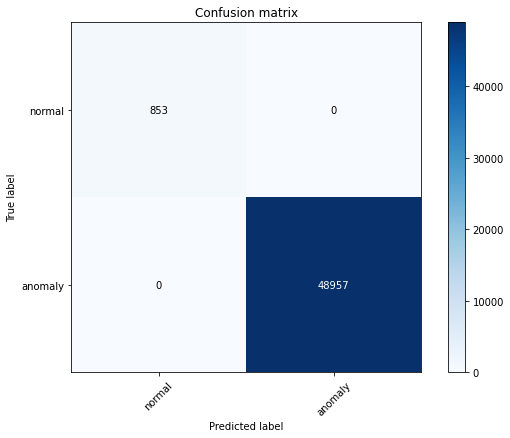


Classification Report:
                precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00      4905

    accuracy                           1.00      4981
   macro avg       1.00      1.00      1.00      4981
weighted avg       1.00      1.00      1.00      4981

train time per 1000 samples=  0.3463119196604533
test time per 1000 samples=  0.006221245867352581


In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # for removing unnecessary warnings
from absl import logging
logging._warn_preinit_stderr = 0
logging.warning('...')
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import itertools
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import joblib
import time

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45) # ,
    plt.yticks(tick_marks, classes) # this line scales y-axis so labels and numbers does not look good in CM

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

t11, f12, f13, f21, t22, f23, f31, f32, t33 = 0, 0, 0, 0, 0, 0, 0, 0, 0
acc = 0

# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
features = ['x', 'y', 'cog', 'sog']
dim = len(features)
timesteps = 60  # number of sequences per batch
CLASSES = 2


data_normal, Y_data = load_all_data(timesteps, dim, features, CLASSES)

num_iter = 10
train_time, test_time = 0, 0
for val in range(num_iter):
    np.random.seed(val)
    data_train, data_test, target_train, target_test = train_test_split(data_normal, Y_data, test_size=0.40)

    start_time = time.time()
    ############ ANN model #######################
    # Create tree classifier
    clf = MLPClassifier(solver='adam', alpha=1e-4,learning_rate='adaptive',
                        hidden_layer_sizes=(100,), random_state=1, verbose=1,
                        tol=1e-5)  # alpha => regularization parameter; random_state => RNG seed
    clf.out_activation_ = 'softmax'
    # Fit the data
    clf.fit(data_train, target_train)
    train_time += (time.time() - start_time)*1000/data_train.shape[0]


    start_time = time.time()
    # Predict the response

    pred = clf.predict_proba(data_test)
    predictLabel=clf.predict(data_test)
    test_time += (time.time() - start_time)*1000/data_test.shape[0]
    
    ###
    dataTest_table=pd.DataFrame(data_test)
    predictLabel_table=pd.DataFrame(predictLabel,columns=['normal','abnormal'])
    truth_values_1=pd.concat([dataTest_table, predictLabel_table], axis=1)
    print(truth_values_1)
    truth_values_1.to_csv("testDataTable.csv", index=False)
        
    # selecting rows based on condition
    abnormalV = truth_values_1[truth_values_1['abnormal'] ==1]
    print('\nAbnormal vessels in dataframe :\n', abnormalV)
    abnormalV.to_csv("AbnormalV.csv", index=False)
    ###

    acc += accuracy_score(target_test.argmax(axis=1), pred.argmax(axis=1))

    if CLASSES ==2:
        r11, r12, r21, r22 = confusion_matrix(target_test.argmax(axis=1), pred.argmax(axis=1)).ravel()
        t11 += r11
        f12 += r12
        f21 += r21
        t22 += r22

    else:

        r11, r12, r13, r21, r22, r23, r31, r32, r33 = confusion_matrix(target_test.argmax(axis=1), pred.argmax(axis=1)).ravel()
        t11 += r11
        f12 += r12
        f13 += r13
        f21 += r21
        t22 += r22
        f23 += r23
        f31 += r31
        f32 += r32
        t33 += r33

    print("Completed run ", val)
if CLASSES == 2:
    print(">>>>>>>>>>>>>>>>>>>>>>>>> \n\n accuracy : ", acc / num_iter)
    cm = np.reshape(np.array([t11, f12, f21, t22]), (2, 2))

    print("\nConfusion Matrix: \n",cm)
    print("\n")
    plot_confusion_matrix(cm, ['normal', 'anomaly'], normalize=False, title='Confusion matrix')
    plt.show()

    print("\nClassification Report:\n ",classification_report(target_test.argmax(axis=1), pred.argmax(axis=1)))

    # save the model to disk
    filename = 'ANN_model_90_2_classes.sav'
    joblib.dump(clf, filename)
else:
    print(">>>>>>>>>>>>>>>>>>>>>>>>> \n\n accuracy : ", acc/num_iter)
    cm = np.reshape(np.array([t11, f12, f13, f21, t22, f23, f31, f32, t33]),(3,3))

    print("\nConfusion Matrix: ",cm)
    print("\n")
    plot_confusion_matrix(cm,['normal','power outage', 'anomaly'], normalize=False, title='Confusion matrix')
    plt.show()

    print("\nClassification Report:\n ",classification_report(target_test.argmax(axis=1), pred.argmax(axis=1)))

    # save the model to disk
    filename = 'ANN_model_90_3_classes.sav'
    joblib.dump(clf, filename)

print('train time per 1000 samples= ', train_time/num_iter)
print('test time per 1000 samples= ', test_time/num_iter)

In [6]:
#trying
print(predictLabel)
pd.DataFrame(predictLabel).to_csv("predictLabel.csv",index=None)    # for anomaly, [0,0,1]; power outage, [0,1,0], normal, [1,0,0]
#trying done!

[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [8]:
import pandas as pd
abnormalV = pd.read_csv("/content/AbnormalV.csv",usecols=['0','1', '2','normal','abnormal'])
abnormalV
abnormalV.rename(columns = {'1':'y', '2':'x'}, inplace = True)
abnormalV

,0,y,x,normal,abnormal
0,8.2,103.717747,1.238428,0,1
1,0.2,103.710757,1.227202,0,1
2,0.1,103.738343,1.198540,0,1
3,0.1,103.797448,1.227710,0,1
4,3.8,103.835342,1.201512,0,1
...,...,...,...,...,...
4900,0.0,103.711067,1.177577,0,1
4901,0.0,103.708312,1.183783,0,1
4902,0.0,103.752528,1.298565,0,1
4903,0.0,103.572267,1.241767,0,1


In [9]:
# data = pd.read_csv("testDataTable.csv")
# data.rename(columns = {'2':'y', '3':'x'}, inplace = True)
# data['abnormal'] = data['abnormal'].astype('bool')  

In [10]:
with open('/content/drive/MyDrive/AISdata (2).csv', 'r') as f:
  data = pd.read_csv(f,skiprows=1,names=['index1', 'date time','mmsi','rot','sog','y','x','cog','true_heading','timestamp','AIS_channel'],usecols=range(1,11))

In [11]:
# Use pandas.merge() to on multiple columns
df2 = pd.merge(data, abnormalV,  how='right', on=['y','x'])
print(df2)

            date time       mmsi  rot  sog           y         x    cog  \
0     10/3/2019 16:04  566287000    0  8.2  103.717747  1.238428   51.1   
1     10/2/2019 15:06  566496000    0  0.2  103.710757  1.227202   42.3   
2     10/2/2019 11:32  566377096    0  0.1  103.738343  1.198540  239.9   
3     10/3/2019 15:12  566377096    0  0.1  103.797448  1.227710  272.5   
4      10/3/2019 0:51  566538000  128  3.8  103.835342  1.201512  111.8   
...               ...        ...  ...  ...         ...       ...    ...   
7464   10/3/2019 5:08  636015937    0  0.0  103.708312  1.183783   98.6   
7465  10/2/2019 22:07  566360000  128  0.0  103.752528  1.298565  271.5   
7466   10/2/2019 9:18  566551000    0  0.0  103.572267  1.241767   31.7   
7467  10/3/2019 14:58  566359000    0  0.0  103.752528  1.298293  276.9   
7468  10/3/2019 16:37  566359000    0  0.0  103.752528  1.298293  276.9   

      true_heading  timestamp AIS_channel    0  normal  abnormal  
0               49          2   

In [12]:
import plotly.express as px

fig = px.scatter_mapbox(df2, lat="x", lon="y", hover_name="mmsi",
                        color_discrete_sequence=["fuchsia"], zoom=8, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()